In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
TAU_M   = 10e-3  
E_LEAK  = -60.0  
V_TH    = -55.0 
TAU_I   = 100e-3  

AMP     = 8.0
V_RESET = -65.0  
DT      = 0.1e-3 
T_TOTAL = 1.0     
TAU_R   = 0.02     

import numpy as np

def lif_simulate(T=T_TOTAL, A=AMP, dt=DT, tau_R=TAU_R, seed=0,
                 tau_m=TAU_M, E=E_LEAK, Vth=V_TH, Vreset=V_RESET, tau_I=TAU_I):

    n = int(T/dt)
    rng = np.random.default_rng(seed)

    V = np.zeros(n)
    V[0] = E
    
    I = np.zeros(n)
    R = np.zeros(n)
    
    spikes = np.zeros(n, dtype=bool)

    for i in range(n-1):
        eta = rng.normal()
        I[i+1] = I[i]*(1 - dt/tau_I) + A*eta*(dt/tau_I)

        dVdt = (E - V[i] + I[i]) / tau_m
        V[i+1] = V[i] + dt*dVdt

        if V[i+1] >= Vth:
            spikes[i+1] = True
            V[i+1] = Vreset

        R[i+1] = R[i] + dt * (-R[i]/tau_R)
        if spikes[i+1]:
            R[i+1] += 1.0/tau_R

    t = np.arange(n)*dt
    mean_rate = spikes.sum() / T
    return t, I, V, spikes, R, mean_rate


Firing Rate 20.5 Hz


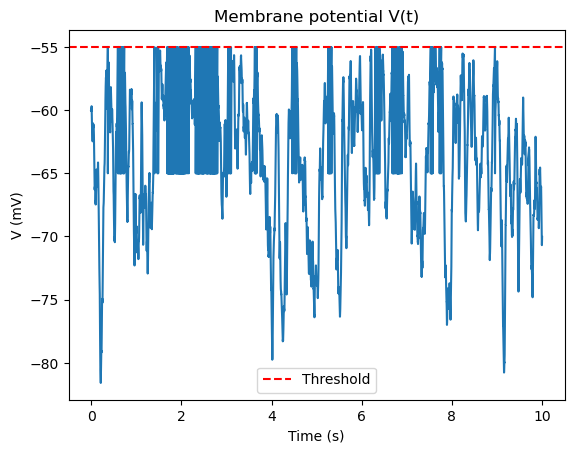

In [31]:
t, I, V, spikes, R, mean_rate = lif_simulate(T=10.0, A=330.0, seed=42)

print("Firing Rate", mean_rate, "Hz")

import matplotlib.pyplot as plt
plt.plot(t, V)
plt.axhline(V_TH, color='r', ls='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("V (mV)")
plt.title("Membrane potential V(t)")
plt.legend()
plt.show()


In [32]:
def test_A_meanrate(A, N=10, T=T_TOTAL, dt=DT, tau_R=TAU_R,
                    tau_m=TAU_M, E=E_LEAK, Vth=V_TH, Vreset=V_RESET, tau_I=TAU_I):

    mean_rates = []
    for s in range(N):
        _, _, _, _, _, mean_rate = lif_simulate(
            T=T, A=A, dt=dt, tau_R=tau_R, seed=s,
            tau_m=tau_m, E=E, Vth=Vth, Vreset=Vreset, tau_I=tau_I
        )
        mean_rates.append(mean_rate)
    return np.mean(mean_rates), mean_rates

In [34]:
avg_rate, rates = test_A_meanrate(A=12.0, N=10, T=2.0)

print("Average Firing Rate:", avg_rate, "Hz")

Average Firing Rate: 0.0 Hz


In [39]:
def test_A_meanrate(A, N=10, T=T_TOTAL, dt=DT, tau_R=TAU_R, tau_m=TAU_M, E=E_LEAK, Vth=V_TH, Vreset=V_RESET, tau_I=TAU_I):
    mean_rates = []
    for s in range(N):
        _, _, _, _, _, mean_rate = lif_simulate(
            T=T, A=A, dt=dt, tau_R=tau_R, seed=s,
            tau_m=tau_m, E=E, Vth=Vth, Vreset=Vreset, tau_I=tau_I
        )
        mean_rates.append(mean_rate)
    return np.mean(mean_rates), mean_rates


def tune_A(target_rate=20.0, start_A=5.0, step=5.0, N=5, min_rate=1.0, max_iter=20, T=T_TOTAL, dt=DT, tau_R=TAU_R, tau_m=TAU_M, E=E_LEAK, Vth=V_TH, Vreset=V_RESET, tau_I=TAU_I):
    A = start_A
    for it in range(max_iter):
        mean_rate, rates = test_A_meanrate(A, N=N, T=T, dt=dt, tau_R=tau_R, tau_m=tau_m, E=E, Vth=Vth, Vreset=Vreset, tau_I=tau_I)
        print(f"[iter {it}] A={A:.2f}, mean_rate={mean_rate:.2f} Hz")
        if mean_rate < min_rate:
            A += step
            continue
        if mean_rate < target_rate:
            A += step
        elif mean_rate > target_rate:
            A -= step
        step *= 0.5
        if abs(mean_rate - target_rate) < 1.0:
            print("Converged!")
            break
    return A, mean_rate


In [ ]:
best_A, best_rate = tune_A(target_rate=20.0, start_A=330.0, step=0.1, N=30, min_rate=20.0, max_iter=100, T=10.0)

print(f"Tuned A = {best_A:.2f}, Average Firing Rate = {best_rate:.2f} Hz")


[iter 0] A=330.00, mean_rate=20.22 Hz
Converged!
Tuned A ≈ 329.90, Average Firing Rate ≈ 20.22 Hz


In [51]:
def compute_rate_from_spikes(spikes, dt=DT, tau_R=TAU_R):
    R = np.zeros_like(spikes, dtype=float)
    for i in range(len(spikes)-1):
        R[i+1] = R[i] + dt * (-R[i]/tau_R)
        if spikes[i+1]:
            R[i+1] += 1.0/tau_R
    return R

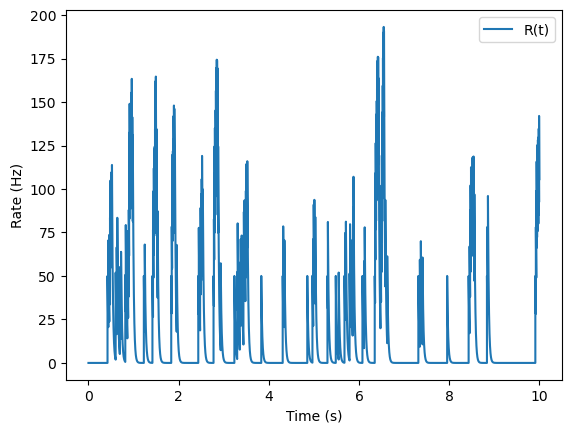

In [53]:
t, I, V, spikes, _, mean_rate = lif_simulate(T=10.0, A=330.0, dt=DT, tau_R=TAU_R)
R = compute_rate_from_spikes(spikes, dt=DT, tau_R=TAU_R)

import matplotlib.pyplot as plt
plt.plot(t, R, label="R(t)")
plt.xlabel("Time (s)")
plt.ylabel("Rate (Hz)")
plt.legend()
plt.show()

In [54]:
def f_relu(I, k=1.0, I0=0.0):
    return k*np.maximum(I-I0,0.0)

def f_softplus(I, k=1.0, I0=0.0, s=5.0):
    return k*np.log1p(np.exp((I-I0)/s))

def simulate_rate(I, dt, tau_R, f, params):
    r = np.zeros_like(I, dtype=float)
    for i in range(len(I)-1):
        r[i+1] = r[i] + (dt/tau_R)*(-r[i] + f(I[i], **params))
    return r

def fit_rate_c(I, R, dt, tau_R, kind="softplus", trials=120, seed=0):
    rng = np.random.default_rng(seed)
    if kind=="relu":
        best=None
        for _ in range(trials):
            I0 = np.quantile(I, rng.uniform(0.4,0.8)) + rng.normal(0,2.0)
            k  = np.exp(rng.normal(np.log(10.0),0.8))
            r  = simulate_rate(I, dt, tau_R, f_relu, {"k":k,"I0":I0})
            e  = np.mean((r-R)**2)
            if (best is None) or (e<best[0]): best=(e,{"k":k,"I0":I0},r)
        return {"f":"relu","params":best[1],"mse":best[0],"r":best[2]}
    else:
        best=None
        for _ in range(trials):
            I0 = np.quantile(I, rng.uniform(0.4,0.8)) + rng.normal(0,2.0)
            k  = np.exp(rng.normal(np.log(10.0),0.8))
            s  = np.exp(rng.normal(np.log(4.0),0.5))
            r  = simulate_rate(I, dt, tau_R, f_softplus, {"k":k,"I0":I0,"s":s})
            e  = np.mean((r-R)**2)
            if (best is None) or (e<best[0]): best=(e,{"k":k,"I0":I0,"s":s},r)
        return {"f":"softplus","params":best[1],"mse":best[0],"r":best[2]}


In [55]:
fit = fit_rate_c(I, R, dt=0.1e-3, tau_R=0.02, kind="softplus", trials=150, seed=0)
r = fit["r"]